# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from collections import Counter

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [21]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [22]:
explore_1 = df.groupby('email')['article_id'].count().sort_values(ascending=False)
len(explore_1)

5148

In [23]:
5148 / 2 

2574.0

In [24]:
explore_1[2575]

3

In [25]:
max(explore_1)

364

In [26]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [27]:
len(df_content)

1056

In [28]:
# Find and explore duplicate articles
sum(df_content.duplicated(['article_id'], keep='first'))

5

In [29]:
# Remove any rows that have the same article_id - only keep the first
df_content_dedupe = df_content.drop_duplicates(['article_id'], keep='first')
len(df_content_dedupe)

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [30]:
explore_2 = df.groupby('article_id')['email'].count()
len(explore_2)

714

In [31]:
sum(explore_1)

45976

In [32]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [33]:
explore_2.sort_values(ascending=False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [34]:
most_viewed_article_id = 1429.0 # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [35]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [36]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The article_id of the most viewed article is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [37]:
id_count = df.groupby('article_id')['user_id'].count()

In [38]:
test = df_content_dedupe.set_index('article_id').join(id_count)
ranked_test = test.sort_values(['user_id'], ascending=False)
ranked_test.head(10)

,doc_body,doc_description,doc_full_name,doc_status,user_id
article_id,,,,,
43,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,This free Deep Learning with TensorFlow course...,Deep Learning With Tensorflow Course by Big Da...,Live,460.0
151,Homepage Sign in / Sign up 3 * Share\r\n * 3\r...,Data science is about learning by doing. One o...,Jupyter Notebook Tutorial,Live,352.0
124,Homepage Sign in / Sign up 9 * Share\r\n * 9\r...,Machine learning studies the design of algorit...,Python Machine Learning: Scikit-Learn Tutorial,Live,325.0
390,Homepage Submission Sign in Get started Homepa...,The purpose of AI systems is to augment human ...,Introducing IBM Watson Studio,Live,270.0
20,Homepage Follow Sign in / Sign up Homepage * H...,It is often useful to use RStudio for one piec...,Working interactively with RStudio and noteboo...,Live,249.0
732,Homepage Follow Sign in / Sign up Homepage * H...,"Flows offer an interactive, graphical environm...",Rapidly build Machine Learning flows with DSX,Live,239.0
1017,We're hiring! | Blog Home * Blog Home\r\n * Le...,An introduction to Pandas. A quick start guide...,The pandas Data Analysis Library,Live,234.0
260,"KDNUGGETS\r\nData Mining, Analytics, Big Data,...",MLDB is an open­source database designed for m...,The Machine Learning Database,Live,222.0
164,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,"In this article, we discuss various Deep Learn...",Learn TensorFlow and Deep Learning Together an...,Live,222.0


In [39]:
test.sort_values(['user_id'], ascending=False).head()

,doc_body,doc_description,doc_full_name,doc_status,user_id
article_id,,,,,
43,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,This free Deep Learning with TensorFlow course...,Deep Learning With Tensorflow Course by Big Da...,Live,460.0
151,Homepage Sign in / Sign up 3 * Share\r\n * 3\r...,Data science is about learning by doing. One o...,Jupyter Notebook Tutorial,Live,352.0
124,Homepage Sign in / Sign up 9 * Share\r\n * 9\r...,Machine learning studies the design of algorit...,Python Machine Learning: Scikit-Learn Tutorial,Live,325.0
390,Homepage Submission Sign in Get started Homepa...,The purpose of AI systems is to augment human ...,Introducing IBM Watson Studio,Live,270.0
20,Homepage Follow Sign in / Sign up Homepage * H...,It is often useful to use RStudio for one piec...,Working interactively with RStudio and noteboo...,Live,249.0


In [40]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    user_count = df.groupby('article_id')['user_id'].count()
    
    article_count = df_content_dedupe.set_index('article_id').join(user_count)
    ranked_article = article_count.sort_values(['user_id'], ascending=False)
    
    top_articles = list(ranked_article['doc_full_name'][:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    user_count = df.groupby('article_id')['user_id'].count()
    
    article_count = df_content_dedupe.set_index('article_id').join(user_count)
    ranked_article = article_count.sort_values(['user_id'], ascending=False)
    
    reset_index = ranked_article.reset_index()
    
    top_articles = list(reset_index['article_id'][:n])
 
    return top_articles # Return the top article ids

In [41]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['Deep Learning With Tensorflow Course by Big Data University', 'Jupyter Notebook Tutorial', 'Python Machine Learning: Scikit-Learn Tutorial', 'Introducing IBM Watson Studio ', 'Working interactively with RStudio and notebooks in DSX', 'Rapidly build Machine Learning flows with DSX', 'The pandas Data Analysis Library', 'The Machine Learning Database', 'Learn TensorFlow and Deep Learning Together and Now!', 'Real-Time Sentiment Analysis of Twitter Hashtags with Spark (+ PixieDust)']
[43, 151, 124, 390, 20, 732, 1017, 260, 164, 681]


In [42]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Oops! The top_5 list doesn't look how we expected.  Try again.
Oops! The top_10 list doesn't look how we expected.  Try again.
Oops! The top_20 list doesn't look how we expected.  Try again.


Got stuck on this piece, will need to review later. 

I have the correct sorted_article list (a couple cells above) but once I join to the deduped content list, they no longer match up. 

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [43]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    matrix = df.pivot_table(index='user_id', columns='article_id', fill_value=0, aggfunc='size')
    matrix[matrix>0] = 1
    
    user_item = pd.DataFrame(matrix)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [44]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [45]:
user_num = len(user_item)
vA = np.array(user_item.loc[5])
user_sim = []

for i in range(1, user_num):
    vB = np.array(user_item.loc[i])
    cos = np.dot(vA, vB) / (np.sqrt(np.dot(vA, vA)) * np.sqrt(np.dot(vB, vB)))
    user_sim.append(cos)    

In [46]:
L1 = list(range(1, len(user_item)))
A1 = np.array(L1)

In [47]:
A2 = np.array(user_sim)

In [48]:
A3 = np.column_stack((A1, A2))
#idx = np.where(A3[:,0] == 5)
idx = list(A3[:,0]).index(5)
idx


4

In [49]:
sim_list = np.column_stack((list(range(1, len(user_item))),user_sim))
sim_list

array([[1.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 9.12870929e-02],
       ...,
       [5.14600000e+03, 0.00000000e+00],
       [5.14700000e+03, 0.00000000e+00],
       [5.14800000e+03, 0.00000000e+00]])

In [50]:
sim_list_df = pd.DataFrame(sim_list).sort_values(by=1, axis=0, ascending=False)
sim_list_df.head()

,0,1
4,5.0,1.000000
3998,3999.0,0.666667
2357,2358.0,0.577350
4111,4112.0,0.577350
2339,2340.0,0.577350


In [51]:
sim_list_df[0].tolist()

[5.0,
 3999.0,
 2358.0,
 4112.0,
 2340.0,
 4288.0,
 1765.0,
 1855.0,
 2554.0,
 4046.0,
 2133.0,
 1381.0,
 1510.0,
 3471.0,
 2189.0,
 3656.0,
 2168.0,
 2313.0,
 4721.0,
 1762.0,
 2818.0,
 4135.0,
 1828.0,
 541.0,
 2213.0,
 3078.0,
 1147.0,
 2634.0,
 2171.0,
 3660.0,
 3333.0,
 2553.0,
 2003.0,
 3157.0,
 1550.0,
 2080.0,
 259.0,
 2555.0,
 2066.0,
 1448.0,
 2455.0,
 3736.0,
 522.0,
 876.0,
 4503.0,
 450.0,
 1566.0,
 3528.0,
 3960.0,
 4.0,
 4366.0,
 1011.0,
 2114.0,
 1027.0,
 4758.0,
 1075.0,
 2063.0,
 2668.0,
 3371.0,
 4816.0,
 2729.0,
 4674.0,
 2969.0,
 4999.0,
 1497.0,
 1645.0,
 167.0,
 1686.0,
 318.0,
 1394.0,
 339.0,
 2257.0,
 690.0,
 4448.0,
 2473.0,
 1217.0,
 3085.0,
 772.0,
 56.0,
 4145.0,
 3060.0,
 2250.0,
 2229.0,
 2141.0,
 4626.0,
 2449.0,
 4178.0,
 1881.0,
 1557.0,
 1411.0,
 2826.0,
 4871.0,
 1754.0,
 4092.0,
 5038.0,
 2971.0,
 4853.0,
 1194.0,
 486.0,
 4203.0,
 3126.0,
 3026.0,
 2813.0,
 1136.0,
 4291.0,
 474.0,
 347.0,
 3474.0,
 4511.0,
 3518.0,
 1137.0,
 5077.0,
 3439.0,
 456

In [52]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_num = len(user_item)
    vA = np.array(user_item.loc[user_id])
    user_sim = []

    for i in range(1, user_num):
        vB = np.array(user_item.loc[i])
        cos = np.dot(vA, vB) / (np.sqrt(np.dot(vA, vA)) * np.sqrt(np.dot(vB, vB)))
        user_sim.append(cos)    
    
    sim_list = np.column_stack((list(range(1, len(user_item))),user_sim))
    
    # sort by similarity
    sorted_sim_df = pd.DataFrame(sim_list).sort_values(by=1, axis=0, ascending=False)
    
    # create list of just the ids
    sorted_list = sorted_sim_df[0].tolist()

    # remove the own user's id
    idx = sorted_list.index(user_id)
    del sorted_list[idx]
    
    most_similar_users = sorted_list
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [53]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933.0, 46.0, 4201.0, 5034.0, 253.0, 824.0, 5041.0, 2305.0, 136.0, 395.0]
The 5 most similar users to user 3933 are: [1.0, 4201.0, 46.0, 5034.0, 253.0]
The 3 most similar users to user 46 are: [4201.0, 790.0, 5077.0]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [54]:
rec_set = set()

In [55]:
find_similar_users(1)[:10]

[3933.0, 46.0, 4201.0, 5034.0, 253.0, 824.0, 5041.0, 2305.0, 136.0, 395.0]

In [59]:
u = set(get_user_articles(1)[0])

In [60]:
i = set(get_user_articles(3933)[0])

In [61]:
r = u.union(i)

In [62]:
rec_set.update(r.difference(u))
print(rec_set)

{234.0, 1165.0, 910.0}


In [63]:
rec_list = list(rec_set)
rec_list[:10]

[234.0, 1165.0, 910.0]

In [64]:
if len(rec_set) < 10:
    pass
else:
    rec_list = list(rec_set)
    rec_list = rec_list[:10]
    
print(rec_list)

[234.0, 1165.0, 910.0]


In [58]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    int_list = list(map(float, article_ids))
    article_names = []
    
    [article_names.append(df.loc[df['article_id'] == i]['title'].iloc[0]) for i in int_list]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_articles = user_item.iloc[user_id] > 0
    article_ids = user_item.columns.values[user_articles]
    
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Finds similar users
    sim_users = list(map(int, find_similar_users(user_id)))
    
    rec_set = set()
    u = set(get_user_articles(user_id)[0])
    
    for s in (sim_users):
        i = set(get_user_articles(s)[0])
        r = u.union(i)
        rec_set.update(r.difference(u))
        if len(rec_set) < m:
            pass
        else:
            rec_list = list(rec_set)
            recs = rec_list[:m]
        
    return recs # return your recommendations for this user_id    

In [65]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'higher-order logistic regression for large datasets',
 'the greatest public datasets for ai – startup grind']

In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

The above tests don't work for whatever reason - I've checked manually the numbers and titles against tests 3-7 and they are correct. 

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [136]:
int_count.iloc[4287]

2

In [137]:
int_count = df.groupby('user_id')['article_id'].count()
test2 = sorted_sim_df.set_index('User_ID')
test = test2.join(int_count)
test.reset_index(inplace=True)
test.head()

,User_ID,Similarity,article_id
0,3999.0,0.666667,4
1,2358.0,0.577350,1
2,4112.0,0.577350,1
3,2340.0,0.577350,1
4,4288.0,0.577350,2


In [168]:
    user_id = 5
    m = 10
    
    # Finds similar users
    ranked_neighbor_id = get_top_sorted_users(user_id)
    sim_users = list(map(int, ranked_neighbor_id.iloc[:,0]))
    
    # Create sets to ensure unique recommendations
    rec_set = set()
    u = set(get_user_articles(user_id)[0])
    
    # Loop to get recs until list is longer than needed
    for s in (sim_users):
        i = set(get_user_articles(s)[0])
        r = u.union(i)
        rec_set.update(r.difference(u))
        if len(rec_set) < m:
            pass
        else:
            rec_list = list(rec_set)
            break
    
    #Rank rec list by total interactions, then prep
    rec_list_df = pd.DataFrame(rec_list).set_index(0)
    int_count2 = df.groupby('article_id')['user_id'].count()
    
    rec_list_int_df = rec_list_df.join(int_count2).reset_index()
    rec_list_int_df.rename(columns={0:"article_id", "user_id":"num_interactions"}, inplace=True)
    rec_list_int_df.sort_values(by='num_interactions', axis=0, ascending=False, inplace=True)
    
    # Outputs
    recs = rec_list_int_df.iloc[:m, 0].tolist()
    rec_names = get_article_names(recs)
    
print(recs)
print(rec_names)

[1330.0, 1304.0, 1271.0, 1172.0, 151.0, 1052.0, 109.0, 1181.0, 1403.0, 210.0]
['insights from new york car accident reports', 'gosales transactions for logistic regression model', 'customer demographics and sales', 'apache spark lab, part 3: machine learning', 'jupyter notebook tutorial', 'access db2 warehouse on cloud and db2 with python', 'tensorflow quick tips', 'car performance data', 'uci: car evaluation', 'this week in data science (february 14, 2017)']


In [158]:
df1 = pd.DataFrame(rec_list).set_index(0)

In [166]:
    int_count2 = df.groupby('article_id')['user_id'].count()
    testA = df1.join(int_count2).reset_index()
    testA.rename(columns={0:"article_id", "user_id":"num_interactions"}, inplace=True)
    testA.sort_values(by="num_interactions", axis=0, ascending=False, inplace=True)
    testB = testA.iloc[:m, 0].tolist()
    testB

[1330.0, 1304.0, 1271.0, 1172.0, 151.0, 1052.0, 109.0, 1181.0, 1403.0, 210.0]

In [175]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    user_num = len(user_item)
    vA = np.array(user_item.loc[user_id])
    user_sim = []

    for i in range(1, user_num):
        vB = np.array(user_item.loc[i])
        cos = np.dot(vA, vB) / (np.sqrt(np.dot(vA, vA)) * np.sqrt(np.dot(vB, vB)))
        user_sim.append(cos)    

    sim_list = np.column_stack((list(range(1, len(user_item))),user_sim))

    # sort by similarity
    sorted_sim_df = pd.DataFrame(sim_list).sort_values(by=1, axis=0, ascending=False)

    # remove the own user's id
    sorted_sim_df.drop(sorted_sim_df[sorted_sim_df[0] == user_id].index, inplace=True)

    # rename column names
    sorted_sim_df.rename(columns={0:"neighbour_id", 1:"similarity"}, inplace=True)

    # set index to user id
    sorted_sim_df.set_index('neighbour_id')

    # get total interations by user_id and join to df
    int_count = df.groupby('user_id')['article_id'].count()
    user_sim_weight_df = sorted_sim_df.join(int_count)

    # rename and sorting
    user_sim_weight_df.rename(columns={"article_id": "num_interactions"}, inplace=True)
    neighbors_df = user_sim_weight_df.sort_values(by=["similarity", "num_interactions"], axis=0, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Finds similar users
    ranked_neighbor_id = get_top_sorted_users(user_id)
    sim_users = list(map(int, ranked_neighbor_id.iloc[:,0]))
    
    # Create sets to ensure unique recommendations
    rec_set = set()
    u = set(get_user_articles(user_id)[0])
    
    # Loop to get recs until list is longer than needed
    for s in (sim_users):
        i = set(get_user_articles(s)[0])
        r = u.union(i)
        rec_set.update(r.difference(u))
        if len(rec_set) < m:
            pass
        else:
            rec_list = list(rec_set)
            break
    
    #Rank rec list by total interactions, then prep
    rec_list_df = pd.DataFrame(rec_list).set_index(0)
    int_count2 = df.groupby('article_id')['user_id'].count()
    
    rec_list_int_df = rec_list_df.join(int_count2).reset_index()
    rec_list_int_df.rename(columns={0:"article_id", "user_id":"num_interactions"}, inplace=True)
    rec_list_int_df.sort_values(by='num_interactions', axis=0, ascending=False, inplace=True)
    
    # Outputs
    recs = rec_list_int_df.iloc[:m, 0].tolist()
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [170]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1271.0, 43.0, 1338.0, 1165.0, 1432.0, 260.0, 1183.0, 1328.0, 57.0, 981.0]

The top 10 recommendations for user 20 are the following article names:
['customer demographics and sales', 'deep learning with tensorflow course by big data university', 'ml optimization using cognitive assistant', 'analyze precipitation data', 'visualize data with the matplotlib library', 'the machine learning database', 'categorize urban density', 'income (2015): united states demographic measures', 'transfer learning for flight delay prediction via variational autoencoders', 'super fast string matching in python']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [181]:
get_top_sorted_users(1).iloc[0,0]

3933.0

In [204]:
get_top_sorted_users(131).iloc[9,0]

383.0

In [214]:
user_id = 131

# compute similarity of each user to the provided user
user_num = len(user_item)
vA = np.array(user_item.loc[user_id])
user_sim = []

for i in range(1, user_num):
    vB = np.array(user_item.loc[i])
    cos = np.dot(vA, vB) / (np.sqrt(np.dot(vA, vA)) * np.sqrt(np.dot(vB, vB)))
    user_sim.append(cos)    

sim_list = np.column_stack((list(range(1, len(user_item))),user_sim))

# sort by similarity
sorted_sim_df = pd.DataFrame(sim_list).sort_values(by=1, axis=0, ascending=False)

# remove the own user's id
sorted_sim_df.drop(sorted_sim_df[sorted_sim_df[0] == user_id].index, inplace=True)

# rename column names
sorted_sim_df.rename(columns={0:"neighbour_id", 1:"similarity"}, inplace=True)
    
sorted_sim_df.head(10)

,neighbour_id,similarity
3869,3870.0,0.986667
202,203.0,0.388909
4458,4459.0,0.388909
3781,3782.0,0.387585
39,40.0,0.384308
4931,4932.0,0.384308
22,23.0,0.377647
241,242.0,0.375823
3909,3910.0,0.372678
382,383.0,0.367423


In [201]:
### Tests with a dictionary of results

user1_most_sim = '3933' # Find the user that is most similar to user 1 
user131_10th_sim = '383' # Find the 10th most similar user to user 131

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

### Test Results

I have user_id 242.0 (the correct answers according to the test) in the 8th position of my results.  This relates back to an earlier issue I had with the tests in that the sort methodology I've used here on df is slightly different.  I've pulled my ranked similiarity results above to show how 242 is in my 8th position.  I'm not sure why this happened, maybe a rounding issue or not removing the users own id?

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [221]:
print(get_top_article_ids(10))
print(get_top_articles(10))

[43, 151, 124, 390, 20, 732, 1017, 260, 164, 681]
['Deep Learning With Tensorflow Course by Big Data University', 'Jupyter Notebook Tutorial', 'Python Machine Learning: Scikit-Learn Tutorial', 'Introducing IBM Watson Studio ', 'Working interactively with RStudio and notebooks in DSX', 'Rapidly build Machine Learning flows with DSX', 'The pandas Data Analysis Library', 'The Machine Learning Database', 'Learn TensorFlow and Deep Learning Together and Now!', 'Real-Time Sentiment Analysis of Twitter Hashtags with Spark (+ PixieDust)']


In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = # Your recommendations here



In [ ]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

## Test Results

I expect the set here is supposed to be a combination of the top users top books, but I think that would be a mistake.  Since we have nothing to go on (with this new user) the assumption that users who read the most have more value as recommendations is false.  The only metric with value is the number of articles that are read the most, in this case found with "get_top_article" and "get_top_article_ids"

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [222]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [223]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [224]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

I believe the difference is that above we were treating a user row as an instance to be compared to every other user instance in parallel, but we can only isolate a single row for comparisons.  SVD gives us the chance to compare every user x user similarity in parallel as a single calculation.  This would make it much easier to do comparisons of similar users, looking at how two unique users compare to the whole.  Or you can compare groups of users to the entire population. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [261]:
print(s_new.shape)
print(u_new.shape)
print(vt_new.shape)

(690, 690)
(5149, 690)
(690, 714)


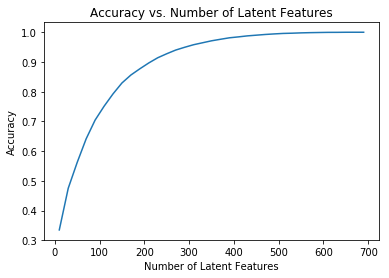

In [229]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [238]:
np.unique(df_test.iloc[:,0])

array([   0.,    2.,    4.,    8.,    9.,   12.,   14.,   15.,   16.,
         18.,   20.,   25.,   26.,   28.,   29.,   30.,   32.,   33.,
         34.,   36.,   39.,   40.,   43.,   48.,   50.,   51.,   53.,
         54.,   57.,   58.,   59.,   60.,   62.,   64.,   65.,   68.,
         74.,   76.,   77.,   78.,   80.,   81.,   82.,   87.,   89.,
         92.,   96.,   98.,  100.,  101.,  102.,  103.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  115.,  116.,  117.,  120.,
        122.,  124.,  125.,  130.,  131.,  132.,  134.,  136.,  138.,
        142.,  143.,  145.,  146.,  151.,  152.,  153.,  157.,  158.,
        162.,  164.,  173.,  176.,  181.,  183.,  184.,  188.,  189.,
        191.,  193.,  194.,  195.,  202.,  205.,  210.,  213.,  215.,
        221.,  223.,  224.,  225.,  230.,  232.,  233.,  234.,  236.,
        237.,  239.,  240.,  241.,  244.,  250.,  251.,  252.,  253.,
        254.,  256.,  258.,  260.,  263.,  266.,  268.,  270.,  273.,
        277.,  278.,

In [239]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test  = create_user_item_matrix(df_test)
    
    test_idx = np.unique(df_test.iloc[:,2])
    test_arts = np.unique(df_test.iloc[:,0])
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [240]:
len(test_idx)

682

In [241]:
len(test_arts)

574

In [253]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

KeyError: 'How many movies can we make predictions for in the test set?'

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [254]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [260]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
print(u_train.shape)
print(s_train.shape)
print(vt_train.shape)

(4487, 4487)
(714,)
(714, 714)


In [263]:
np.allclose(user_item_train, np.dot(u_train[:, :714] * s_train, vt_train))

True

In [264]:
smat = np.zeros((4487, 714), dtype=complex)
smat[:714, :714] = np.diag(s_train)
np.allclose(user_item_train, np.dot(u_train, np.dot(smat, vt_train)))

True

In [276]:
diffs = np.subtract(user_item_train, np.dot(u_train[:, :714] * s_train, vt_train))
np.around(diffs)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
2,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
3,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
4,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
5,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
6,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
7,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
8,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
9,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**



<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])